# 💡 MosaicX: **Example: Simple pendulum**

> All code and examples are shared to help researchers, students, and engineers understand the reasoning behind DDDA — and to make it easy to apply dimensional analysis to your own data.  
> This notebook serves as an entry-level guide for teaching, validating physical models, and enabling domain-specific knowledge engineering through data-driven dimensional reasoning.

---

## 🎯 What You'll Learn

**隐函数最优显式化 - 机器科学家应用**

In this notebook, we will walk through the theoretical and computational foundation of **dimensional analysis**, with a focus on the **Buckingham Pi theorem**. You will learn:

1. **物理模型，隐函数，流形**  
   Understand why we reduce variables and how dimensional consistency enables model generalization.

2. **变量组合**  
   Encode physical units of input quantities using base units and build the D-matrix.

3. **变量组合评估**  
   Discover dimensionless groups by solving linear algebraic equations on the D-matrix.

4. **显式化策略可视化**  
   Learn to assess whether derived groups make physical and computational sense.

5. **不确定性定量化**  
   Set the stage for further steps in the DDDA pipeline including Pi-group selection, uncertainty quantification, and regime detection.

---

## 👤 Author

- **Name**: Jiashun Pang  
- **Created**: August 2025  
- **Affiliation**: DDDA Project, open research notebook  
- **Notebook Focus**:  
  A hands-on exploration of dimensional analysis — from aggregated raw quantities to symbolic Pi-group discovery and preparation for downstream DDDA tasks.

---

📌 *This notebook is designed to be accessible for learners new to dimensional analysis, while also laying the foundation for advanced applications in the full MosaicPi pipeline.*


# 1. 单摆控制方程

下面用**能量守恒**把单摆方程一步步推出来；这是最直接、最“由守恒律来”的推导。结论会是

$$
\boxed{\ \ddot\theta+\frac{g}{L}\sin\theta=0\ }
$$

**理想化假设**：细而不可伸长的轻绳/刚杆，摆球质量 $m$，摆长 $L$，铰接无摩擦，仅受重力，无空气阻力。

---

## 1.1 普适化处理
在普适化处理阶段，我们仅采用**无量纲化**以消除单位影响并凸显方程的本征结构。由于研究重点在于**函数的结构分析**及**状态分布**的保持，诸如归一化、标准化与正则化等数值预处理方法均不适用，因此在此环节中被排除。

* **无量纲化**：令 $\tau = t\sqrt{g/L}$，则

  $$
  \theta''(\tau) + \sin\theta = 0,
  $$

  其中 $'$ 为对 $\tau$ 的导数。

---

## 1.2 结构化转化
在进入 Jacobian 分析之前，我们首先需要对单摆方程进行结构化转化，将原始的二阶非线性ODE改写为更适合分析的形式（如一阶系统或残差形式），以便在后续能够从不同视角开展稳定性、可逆性与函数结构的判定。

### 1.2.1 一阶系统化（state-space form）

$$
x_1 = \theta, \quad x_2 = \theta' \,,
$$

系统变为：

$$
\begin{cases}
x_1' = x_2 \\
x_2' = -\sin(x_1)
\end{cases}
$$

这个形式便于写成向量函数：

$$
\mathbf{x}' = f(\mathbf{x}) = 
\begin{bmatrix}
x_2 \\
-\sin(x_1)
\end{bmatrix}
$$

---

### 1.2.2 残差形式（residual form）

$$
F(\theta, \theta', \theta'') = \theta'' + \sin\theta = 0
$$

* 在这个视角下，$(\theta, \theta', \theta'')$ 是独立变量；
* 方程 $F=0$ 定义了一个“函数流形”；
* 你可以对 $F$ 做偏导，得到残差形式下的 Jacobian。

---

## 1.3 Jacobian 的两种切入点

* **一阶系统视角**：Jacobian 是

  $$
  J = \frac{\partial f}{\partial x} 
  = \begin{bmatrix}
  \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} \\
  \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2}
  \end{bmatrix}
  =
  \begin{bmatrix}
  0 & 1 \\
  -\cos(x_1) & 0
  \end{bmatrix}
  $$

* **残差形式视角**：Jacobian 是

  $$
  J = \left[ \frac{\partial F}{\partial \theta}, \frac{\partial F}{\partial \theta'}, \frac{\partial F}{\partial \theta''} \right]
  = \big[ \cos\theta, \; 0, \; 1 \big]
  $$

前者用于稳定性分析（动力系统的流形局部线性化），后者用于隐函数分析（解的显函数化、函数结构判定）。

---



# 2. 单摆模型函数结构与空间定义
我们要对单摆模型的Jacobian使用

> 在 MosaicX 的框架下，我们通常从残差形式出发，以保证对动力系统与非动力系统的一致处理。然而，在 Jacobian 的数值诊断（如行列式、条件数和奇异值分解）上，残差形式往往退化为非方阵，不利于谱特性的定量化分析。因此在数值层面，我们进一步采用一阶系统化的转化，以获得方阵 Jacobian，从而更稳定地开展 det、cond 与 $\sigma_{\min}$ 的计算。
---

## 2.1 Jacobian格式选择

残差形式天然的能够揭示**函数流形的存在性与显函数化条件**，但在数值诊断上往往因 Jacobian 退化为非方阵而受限，无法直接开展行列式、条件数或奇异值分析。相比之下，一阶系统化在动力系统场景下提供了一个方阵 Jacobian，使得谱特性分析得以顺利进行，从而更适合 det/cond/SVD 等定量化诊断。

需要强调的是：

* **适用范围**：这一结论主要成立于动力系统（ODE/PDE）类问题中，因为它们天然可以转化为状态空间形式；
* **无损性**：从残差形式到一阶系统形式，本质上是对高阶导数引入中间变量的“重写”，方程的信息并未丢失，因此结果是无损的；
* **非动力系统**：对于一般非动力学约束问题（纯代数方程或守恒关系），我们对模型会有封闭性要求，所以方阵问题不存在。

### 2.1.1残差形式的局限

在残差形式下，比如单摆

$$
F(\theta, \theta', \theta'') = \theta'' + \sin\theta = 0,
$$

Jacobian 是一行向量：

$$
J = \big[\cos\theta,\;0,\;1\big].
$$

* 这是一个 **1×3 矩阵**，没有方阵结构：

  * $\det(J)$ 没有定义；
  * $\kappa(J)$（条件数）不具备传统意义；
  * SVD 的最小奇异值 $\sigma_{\min}$ 也只给出“这个行向量的最小拉伸”，无法反映整体结构的可逆性。
* 在单摆的例子中，**残差形式适合逻辑判定（能否显函数化），但不适合数值诊断（det/cond/SVD）**。

---

### 2.1.2 一阶系统化的优势

把它转为一阶系统：

$$
\begin{cases}
x_1' = x_2 \\
x_2' = -\sin(x_1)
\end{cases}
$$

对应向量场

$$
f(x_1,x_2) = \begin{bmatrix} x_2 \\ -\sin(x_1)\end{bmatrix},
$$

Jacobian 是

$$
J = \begin{bmatrix}
0 & 1 \\
-\cos(x_1) & 0
\end{bmatrix}.
$$

* 这是一个 **方阵 (2×2)**：

  * $\det(J) = \cos(x_1)$ 可用于奇异性判定；
  * $\kappa(J)$ 条件数反映了局部线性化的敏感性；
  * SVD 的奇异值给出主方向上的放缩因子，能量化系统的局部刚性/脆弱性。

所以在这个例子中 **一阶系统视角更适合做数值诊断 (det/cond/SVD)**。

---


In [1]:
import sympy as sp

# --- 1) 无量纲单摆：theta'' + sin(theta) = 0 ---
tau = sp.symbols('tau')           # 无量纲时间
theta = sp.Function('theta')(tau)

# --- 2) 一阶系统化 ---
x1, x2 = sp.symbols('x1 x2')      # x1 = theta, x2 = theta'
f1 = x2
f2 = -sp.sin(x1)

f = sp.Matrix([f1, f2])
x = sp.Matrix([x1, x2])

# --- 3) Jacobian ---
J = f.jacobian(x)                  # ∂f/∂x
sp.pprint(J)

# 可选：给出数值点处的评估（例如 x1 = pi/3, x2 = 0.2）
J_num = J.subs({x1: sp.pi/3, x2: 0.2})
print("\nJ(pi/3, 0.2) =")
sp.pprint(J_num)


⎡   0      1⎤
⎢           ⎥
⎣-cos(x₁)  0⎦

J(pi/3, 0.2) =
⎡ 0    1⎤
⎢       ⎥
⎣-1/2  0⎦


# 3. 相空间迭代求解

我们将从动力学的代数结构和动力学轨迹类指标通过自适应网格进行整个空间的高效扫描，知道探索出理论上的空间结构信息。
## 3.1 原始网格取样与相空间地图
在已得到向量场 $f(x)$ 与 Jacobian $J(x)=\partial f/\partial x$ 之后，本阶段的目标是：**在相空间 $(\theta,\dot\theta)$ 上构建一张“粗分辨率的结构地图”**。做法是在给定范围内（如 $\theta\in[-\pi,\pi]$, $\dot\theta\in[-2,2]$）布置均匀网格，对每个格点计算一组与可解性/敏感性相关的指标，用于后续的自适应细化与显函数拼贴（patches atlas）。

### 3.1.1 相空间采样与采样点**代数结构**指标
选定主值区间与速度范围，布置 \$N\_1\times N\_2\$ 的均匀网格，保证覆盖典型动力学区域并便于可视化（注意 \$\theta\$ 的周期性边界处理）。

**采样点代数指标**：在每个格点用 \$J(x)\$ 计算 \$\det J\$、\$\operatorname{tr}J\$、奇异值 \$\sigma\_{\min},\sigma\_{\max}\$、条件数 \$\kappa=\sigma\_{\max}/\sigma\_{\min}\$、谱半径 \$\rho(J)\$。这些量直接反映**局部可逆性与数值病态**（如 \$\sigma\_{\min}\to 0\$ 的“近奇异带”）。

---

**代数指标的数学含义与解释**

* **行列式 \$\det J = \cos\theta\$**

  * 决定局部相空间映射的体积伸缩性。
  * 当 \$\cos\theta=0\$（即 \$\theta=\pm \pi/2\$）时，Jacobian 退化，局部线性近似失效，提示系统在这些分界角度存在“结构性脆弱点”。

* **迹 \$\operatorname{tr} J = 0\$**

  * 对二维系统而言，迹给出特征值之和。恒为零意味着特征值总是 \$\pm \lambda\$ 对称出现，即该系统的线性化动力学不可能呈现单一的指数收缩或发散，而是**相空间局部平衡的“鞍点—中心”型结构**。

* **奇异值 \$\sigma\_{\min}, \sigma\_{\max}\$**

  * 刻画了 \$J\$ 在不同方向上的局部伸缩比率。
  * 当 \$\sigma\_{\min}\to 0\$ 时，意味着某些方向上的灵敏度极低，相当于“近奇异”；而 \$\sigma\_{\max}\$ 代表最强的放大方向。

* **条件数 \$\kappa = \sigma\_{\max}/\sigma\_{\min}\$**

  * 衡量 \$J\$ 的各向异性程度。
  * 条件数大 → 局部坐标方向高度不均衡，说明在该点上**数值稳定性差**、敏感性强。

* **谱半径 \$\rho(J)\$**

  * 即 \$J\$ 的最大特征值模。
  * 对应于局部线性动力学的“最强指数效应”。若 \$\rho(J)>1\$，表明在该点线性近似下存在放大趋势（即局部不稳定）；若 \$\rho(J)<1\$，则趋向收缩。

---

### 总结

这一层的分析完全是\*\*点态（algebraic, 静态）\*\*的：

* 它不涉及真实时间演化，而是考察“如果在某个点做线性化，Jacobian 给出的局部几何特征”。
* 这些指标在 MosaicX 的 pipeline 中起到 **结构图谱绘制** 的作用，可以帮助识别：

  1. 哪些区域是“近奇异带”或“病态带”；
  2. 哪些区域的相空间演化可能存在强放大/收缩；
  3. 整个相空间的基本对称性与分区。

---



In [4]:
# mosaicx_pendulum_phase_map_algebraic.py
# Section 3.1.1: Coarse phase-space sampling and algebraic indicators (NO energy, NO FTLE)
#
# System (nondimensional pendulum):
#   x1' = x2
#   x2' = -sin(x1)
#
# Indicators per grid point (x1=theta, x2=theta_dot):
# - detJ, trJ
# - sigma_min, sigma_max, cond2 (2-norm condition number)
# - spectral_radius (rho(J))
# - near_singular flag (sigma_min < eps_sigma)
#
# Output: CSV with one row per initial state

import numpy as np
import pandas as pd
from typing import Tuple

# ---------- 1) Build symbolic model & lambdify ----------
import sympy as sp

# States and vector field
x1, x2 = sp.symbols('x1 x2', real=True)
f1 = x2
f2 = -sp.sin(x1)
f = sp.Matrix([f1, f2])

# Jacobian J = df/dx  -> [[0, 1], [-cos(x1), 0]]
J_sym = f.jacobian(sp.Matrix([x1, x2]))

# Handy symbolic pieces
detJ_sym = sp.simplify(J_sym.det())       # = cos(x1)
trJ_sym  = sp.simplify(sp.trace(J_sym))   # = 0

# Lambdify vector field and Jacobian (f is kept for completeness; not used here)
f_np   = sp.lambdify((x1, x2), f, 'numpy')       # returns 2x1
J_np   = sp.lambdify((x1, x2), J_sym, 'numpy')   # returns 2x2
detJ_f = sp.lambdify((x1, x2), detJ_sym, 'numpy')
trJ_f  = sp.lambdify((x1, x2), trJ_sym,  'numpy')

# ---------- 2) Pointwise algebraic indicators from J ----------
def jacobian_indicators(J: np.ndarray) -> Tuple[float, float, float, float, float, float]:
    """
    From a 2x2 Jacobian J, compute:
      detJ, trJ, sigma_min, sigma_max, cond2, spectral_radius
    """
    detJ = float(np.linalg.det(J))
    trJ  = float(np.trace(J))
    # singular values (2-norm)
    svals = np.linalg.svd(J, compute_uv=False)
    sigma_max = float(np.max(svals))
    sigma_min = float(np.min(svals))
    cond2 = sigma_max / (sigma_min + 1e-30)
    # spectral radius (max |eigenvalue|)
    evals = np.linalg.eigvals(J)
    spectral_radius = float(np.max(np.abs(evals)))
    return detJ, trJ, sigma_min, sigma_max, cond2, spectral_radius

# ---------- 3) Grid driver (uniform, pre-adaptation; algebraic-only) ----------
def compute_phase_map_algebraic(
    N1: int = 41, N2: int = 41,
    x1_min: float = -np.pi, x1_max: float = np.pi,
    x2_min: float = -2.0,  x2_max: float =  2.0,
    eps_sigma: float = 1e-3,
    avoid_theta_dup: bool = True
) -> pd.DataFrame:
    """
    Section 3.1.1: Build a coarse structural map on phase space (theta, theta_dot)
    using algebraic indicators derived from J(x). No FTLE here.

    Parameters
    ----------
    N1, N2 : grid resolution in theta and theta_dot
    x1_min, x1_max : range for theta (use principal interval)
    x2_min, x2_max : range for theta_dot
    eps_sigma : threshold for near-singular flag (sigma_min < eps_sigma)
    avoid_theta_dup : if True, uses endpoint=False to avoid duplicate (-pi, pi)

    Returns
    -------
    DataFrame with one row per grid point containing:
      x1_theta, x2_theta_dot, detJ, trJ, sigma_min, sigma_max, cond2,
      spectral_radius_J, near_singular
    """
    # For the angular coordinate, avoid duplicating two periodic endpoints
    if avoid_theta_dup:
        x1_vals = np.linspace(x1_min, x1_max, N1, endpoint=False)
    else:
        x1_vals = np.linspace(x1_min, x1_max, N1)
    x2_vals = np.linspace(x2_min, x2_max, N2)

    rows = []
    for th in x1_vals:
        for thdot in x2_vals:
            # Jacobian at (theta, theta_dot)
            J = np.array(J_np(th, thdot), dtype=float)
            detJ, trJ, smin, smax, cond2, rhoJ = jacobian_indicators(J)

            rows.append({
                "x1_theta": th,
                "x2_theta_dot": thdot,
                "detJ": detJ,
                "trJ": trJ,
                "sigma_min": smin,
                "sigma_max": smax,
                "cond2": cond2,
                "spectral_radius_J": rhoJ,
                "near_singular": bool(smin < eps_sigma)
            })

    return pd.DataFrame(rows)

# ---------- 4) Main ----------
if __name__ == "__main__":
    # You can tweak these to match the notebook narrative (Section 3.1.1)
    N1, N2 = 41, 41
    x1_min, x1_max = -np.pi, np.pi      # principal interval for theta
    x2_min, x2_max = -2.0, 2.0          # symmetric speed range
    eps_sigma = 1e-3
    out_csv = "pendulum_phase_map_algebraic.csv"

    df = compute_phase_map_algebraic(
        N1=N1, N2=N2,
        x1_min=x1_min, x1_max=x1_max,
        x2_min=x2_min, x2_max=x2_max,
        eps_sigma=eps_sigma,
        avoid_theta_dup=True
    )
    df.to_csv(out_csv, index=False)

    # Small console summary (algebraic-only)
    print(f"Saved {len(df)} rows to {out_csv}")
    for k in ["sigma_min", "cond2", "spectral_radius_J"]:
        arr = df[k].to_numpy()
        print(f"{k:>18s}  min={arr.min(): .3e}  med={np.median(arr): .3e}  max={arr.max(): .3e}")
    print(f"near_singular count: {df['near_singular'].sum()} (threshold eps_sigma={eps_sigma})")


Saved 1681 rows to pendulum_phase_map_algebraic.csv
         sigma_min  min= 3.830e-02  med= 7.205e-01  max= 1.000e+00
             cond2  min= 1.000e+00  med= 1.388e+00  max= 2.611e+01
 spectral_radius_J  min= 1.957e-01  med= 8.488e-01  max= 1.000e+00
near_singular count: 0 (threshold eps_sigma=0.001)


绘制分区图

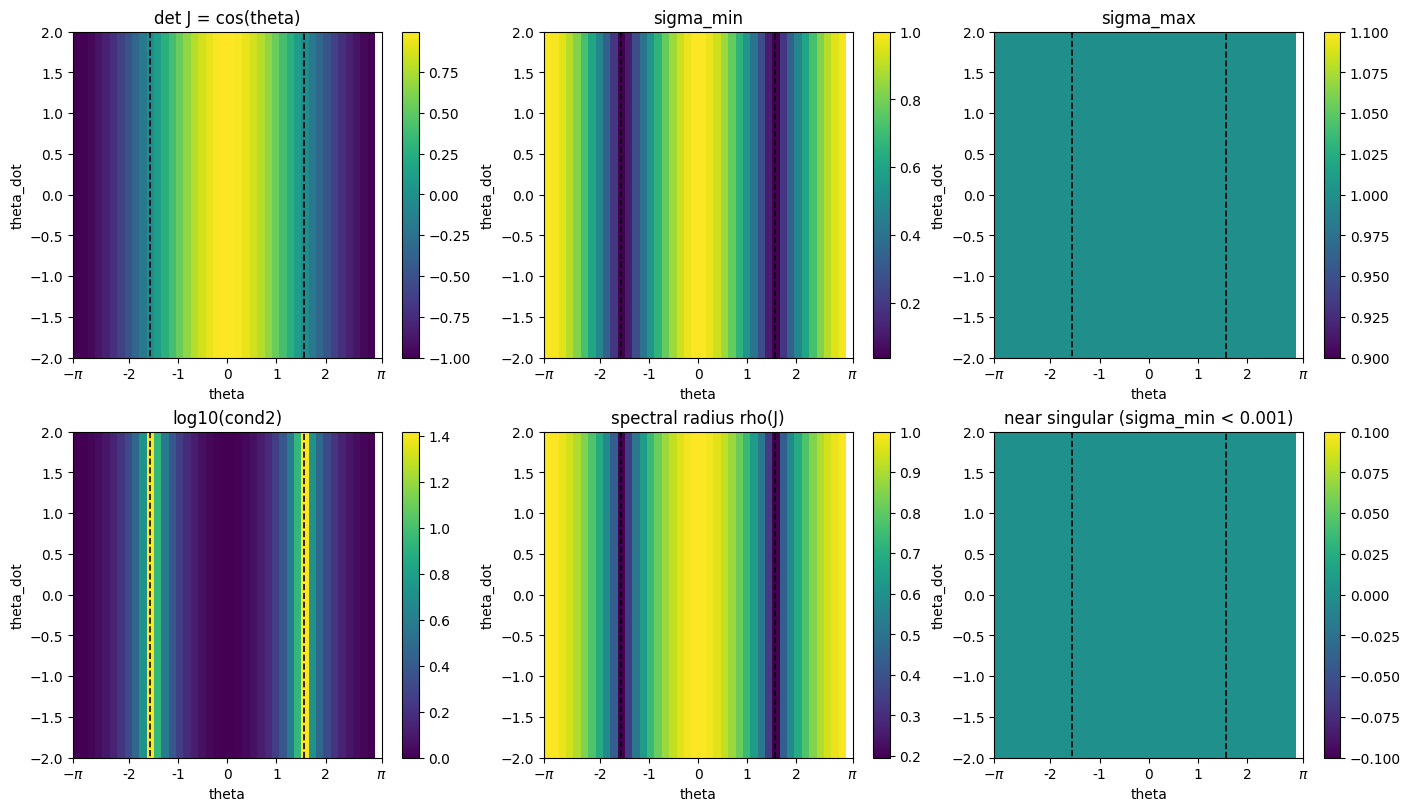

In [7]:
# viz_pendulum_phase_algebraic.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("pendulum_phase_map_algebraic.csv")

# 网格维度（与你生成时一致）
N1 = df['x1_theta'].nunique()
N2 = df['x2_theta_dot'].nunique()

# 还原网格
theta_vals = np.sort(df['x1_theta'].unique())
thetadot_vals = np.sort(df['x2_theta_dot'].unique())

def to_grid(col):
    Z = df.pivot(index='x2_theta_dot', columns='x1_theta', values=col).values
    # 注意 pivot 后行是 x2（从小到大），imshow 的原点在左上，设置 origin='lower'
    return Z

detJ = to_grid('detJ')
smin  = to_grid('sigma_min')
smax  = to_grid('sigma_max')
kappa = to_grid('cond2')
rhoJ  = to_grid('spectral_radius_J')

# 近奇异掩膜（与脚本一致）
eps_sigma = 1e-3
near_sing = to_grid('near_singular').astype(bool)

extent = [theta_vals.min(), theta_vals.max(), thetadot_vals.min(), thetadot_vals.max()]

def add_det_zero_contour(ax):
    # 画 detJ=0 等值线（即 cos(theta)=0 的两条竖线）
    ax.contour(
        theta_vals,
        thetadot_vals,
        detJ,
        levels=[0.0],
        linewidths=1.2,
        linestyles='--',
        colors='k'
    )

fig, axs = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)

# detJ
im0 = axs[0,0].imshow(detJ, extent=extent, origin='lower', aspect='auto')
axs[0,0].set_title('det J = cos(theta)')
add_det_zero_contour(axs[0,0]); fig.colorbar(im0, ax=axs[0,0])

# sigma_min
im1 = axs[0,1].imshow(smin, extent=extent, origin='lower', aspect='auto')
axs[0,1].set_title('sigma_min')
add_det_zero_contour(axs[0,1]); fig.colorbar(im1, ax=axs[0,1])

# sigma_max
im2 = axs[0,2].imshow(smax, extent=extent, origin='lower', aspect='auto')
axs[0,2].set_title('sigma_max')
add_det_zero_contour(axs[0,2]); fig.colorbar(im2, ax=axs[0,2])

# log10(kappa)
kappa_log = np.log10(np.clip(kappa, 1.0, 1e16))
im3 = axs[1,0].imshow(kappa_log, extent=extent, origin='lower', aspect='auto')
axs[1,0].set_title('log10(cond2)')
add_det_zero_contour(axs[1,0]); fig.colorbar(im3, ax=axs[1,0])

# spectral radius
im4 = axs[1,1].imshow(rhoJ, extent=extent, origin='lower', aspect='auto')
axs[1,1].set_title('spectral radius rho(J)')
add_det_zero_contour(axs[1,1]); fig.colorbar(im4, ax=axs[1,1])

# 近奇异带（布尔图）
im5 = axs[1,2].imshow(near_sing, extent=extent, origin='lower', aspect='auto')
axs[1,2].set_title(f'near singular (sigma_min < {eps_sigma:g})')
add_det_zero_contour(axs[1,2]); fig.colorbar(im5, ax=axs[1,2])

for ax in axs.ravel():
    ax.set_xlabel('theta'); ax.set_ylabel('theta_dot')
# 在绘图循环后，加上统一的刻度设置
for ax in axs.ravel():
    ax.set_xlabel('theta')
    ax.set_ylabel('theta_dot')
    # 设置横坐标刻度，覆盖 [-π, π]
    ax.set_xticks([-np.pi, -2, -1, 0, 1, 2, np.pi])
    ax.set_xticklabels([r'$-\pi$', '-2', '-1', '0', '1', '2', r'$\pi$'])
plt.savefig('pendulum_phase_algebraic_maps.png', dpi=200)
plt.show()


#### det J 热力图 **解释：**
* 由于雅可比矩阵

  $$
  J(\theta) = \begin{bmatrix}
  0 & 1 \\[6pt]
  -\cos\theta & 0
  \end{bmatrix},
  $$

  它的行列式正好是

  $$
  \det J = \cos\theta,
  $$

  与 $\dot\theta$ 无关。
  因此整张图呈现**竖条状结构**：颜色只随横坐标 $\theta$ 变化，而与纵坐标 $\dot\theta$ 无关。

* 颜色条显示了 $\cos\theta$ 的取值范围：

  * **正值区**对应于 $-\pi/2 < \theta < \pi/2$，此时局部线性化的特征值是**纯虚数**，表现为**中心型动力学**（小角度单摆稳定振荡）。
  * **负值区**对应于 $\pi/2 < |\theta| < \pi$，此时特征值为实数异号，表现为**鞍点型动力学**（倒立位置的不稳定平衡）。

* 图中叠加的虚线等值线是 $\det J=0$（即 $\theta=\pm\pi/2$），它清楚地把相空间分为两类区域：

> * 判别条件：
>
>   * **中心区**：$\det J > 0$，特征值为纯虚数，局部动力学为中心型；
>   * **鞍点区**：$\det J < 0$，特征值为实数异号，局部动力学为鞍点型；
>   * **分界带**：$\det J = 0$，Jacobian 退化，出现近奇异。
> * 在单摆系统中，$\det J = \cos\theta$，因此分区条件具体为：
>
>   * 中心区：$\cos\theta > 0$（小角度稳定振荡）；
>   * 鞍点区：$\cos\theta < 0$（倒立摆不稳定）；
>   * 分界带：$\cos\theta = 0$（水平位置）。

---



In [8]:
# === Prep: load & grid ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("pendulum_phase_map_algebraic.csv")

# unique grids
theta_vals    = np.sort(df['x1_theta'].unique())
thetadot_vals = np.sort(df['x2_theta_dot'].unique())

def to_grid(col):
    # pivot -> Z[y_index, x_index]
    return df.pivot(index='x2_theta_dot', columns='x1_theta', values=col).values

detJ  = to_grid('detJ')
smin  = to_grid('sigma_min')
smax  = to_grid('sigma_max')
kappa = to_grid('cond2')
rhoJ  = to_grid('spectral_radius_J')
near_sing = to_grid('near_singular').astype(bool)

# extent：按单元“边界”来画，避免 +π 被视觉截断
dx = float(np.diff(theta_vals).mean())
dy = float(np.diff(thetadot_vals).mean())
extent = [
    theta_vals.min() - 0.5*dx, theta_vals.max() + 0.5*dx,
    thetadot_vals.min() - 0.5*dy, thetadot_vals.max() + 0.5*dy
]

# helper: 叠加 detJ=0 等值线（θ = ±π/2）
def add_det_zero_contour(ax):
    ax.contour(
        theta_vals, thetadot_vals, detJ,
        levels=[0.0], linewidths=1.4, linestyles='--', colors='k'
    )

# helper: 横轴用弧度常见刻度（也可换角度，见注释）
def set_ticks_rad(ax):
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
    ax.set_xlabel('theta'); ax.set_ylabel('theta_dot')

# # 若想显示角度（°），用下面替换：
# import matplotlib.ticker as mticker
# def set_ticks_deg(ax):
#     ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{int(np.degrees(v))}°"))
#     ax.set_xlabel('theta (deg)'); ax.set_ylabel('theta_dot')


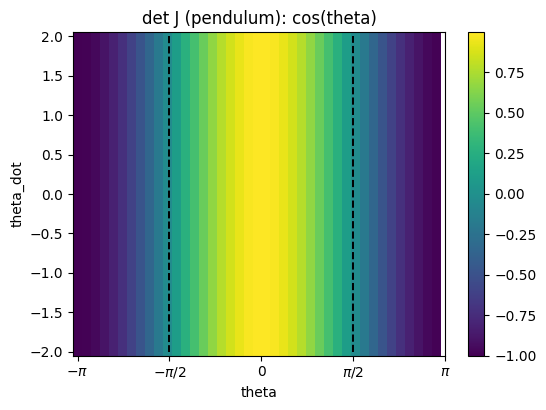

In [9]:
fig, ax = plt.subplots(figsize=(6,4.2))
im = ax.imshow(detJ, extent=extent, origin='lower', aspect='auto')
ax.set_title('det J (pendulum): cos(theta)')
add_det_zero_contour(ax); set_ticks_rad(ax)
plt.colorbar(im, ax=ax)
plt.show()


#### det J 热力图 **解释：**
* 由于雅可比矩阵

  $$
  J(\theta) = \begin{bmatrix}
  0 & 1 \\[6pt]
  -\cos\theta & 0
  \end{bmatrix},
  $$

  它的行列式正好是

  $$
  \det J = \cos\theta,
  $$

  与 $\dot\theta$ 无关。
  因此整张图呈现**竖条状结构**：颜色只随横坐标 $\theta$ 变化，而与纵坐标 $\dot\theta$ 无关。

* 颜色条显示了 $\cos\theta$ 的取值范围：

  * **正值区**对应于 $-\pi/2 < \theta < \pi/2$，此时局部线性化的特征值是**纯虚数**，表现为**中心型动力学**（小角度单摆稳定振荡）。
  * **负值区**对应于 $\pi/2 < |\theta| < \pi$，此时特征值为实数异号，表现为**鞍点型动力学**（倒立位置的不稳定平衡）。

* 图中叠加的虚线等值线是 $\det J=0$（即 $\theta=\pm\pi/2$），它清楚地把相空间分为两类区域：

> * 判别条件：
>
>   * **中心区**：$\det J > 0$，特征值为纯虚数，局部动力学为中心型；
>   * **鞍点区**：$\det J < 0$，特征值为实数异号，局部动力学为鞍点型；
>   * **分界带**：$\det J = 0$，Jacobian 退化，出现近奇异。
> * 在单摆系统中，$\det J = \cos\theta$，因此分区条件具体为：
>
>   * 中心区：$\cos\theta > 0$（小角度稳定振荡）；
>   * 鞍点区：$\cos\theta < 0$（倒立摆不稳定）；
>   * 分界带：$\cos\theta = 0$（水平位置）。

---



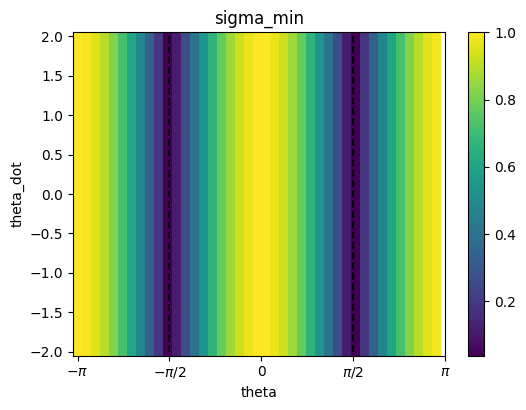

In [10]:
fig, ax = plt.subplots(figsize=(6,4.2))
im = ax.imshow(smin, extent=extent, origin='lower', aspect='auto')
ax.set_title('sigma_min')
add_det_zero_contour(ax); set_ticks_rad(ax)
plt.colorbar(im, ax=ax)
plt.show()



### `sigma_min` 热力图怎么读

* 对单摆一阶系统

  $$
  J(\theta)=\begin{bmatrix}0&1\\ -\cos\theta&0\end{bmatrix},
  $$

  奇异值是 $J^TJ$ 的特征值开方。这里

  $$
  J^TJ=\begin{bmatrix}\cos^2\theta&0\\ 0&1\end{bmatrix}\;\Rightarrow\;
  \sigma_{\max}=1,\quad \sigma_{\min}=|\cos\theta|.
  $$

  所以：

  * **σ\_max 恒为 1**（整图一条水平“常值层”）；
  * **σ\_min = |\cos\theta|**，只随 $\theta$ 变、不随 $\dot\theta$ 变 ⇒ 图上呈**竖向条纹**。

* 图中的**虚线**是 $\det J=0$ 的等值线（$\theta=\pm \pi/2$）。
  在这些线附近，$|\cos\theta|\to 0\Rightarrow \sigma_{\min}\to 0$，颜色最暗——这就是 **“近奇异带”**（局部最不稳定、数值最病态的方向）。

* 物理/数值含义

  * $\sigma_{\min}$ 衡量“**最不灵敏方向**”的线性放大率；越小表示越接近雅可比不可逆。
  * 本系统中 $\kappa=\sigma_{\max}/\sigma_{\min}=1/|\cos\theta|$ 会在 $\theta=\pm\pi/2$ **发散**，与你的 `near_singular` 掩膜一致。
  * 因为 $\sigma_{\min}$ 取绝对值，不区分 $\cos\theta$ 正负，所以它标出的是**病态强度**，而不是动力学类型的正负；动力学“中心/鞍点”需要看 $\det J$（含符号）。

* 读图要点

  1. 亮色（$\sigma_{\min}\approx1$）出现在 $\theta\approx k\pi$ 附近：局部可逆性充足、病态弱；
  2. 暗色（$\sigma_{\min}\approx0$）沿 $\theta=\pm\pi/2$：**显函数 patch 的边界/过渡带**；
  3. 与 `det J` 图配合：`det J` 给**类型与分区**（正/负/零），`σ_min` 给**病态强度与边界厚度**。

> 小结：这张图把“哪里最接近失去可逆性（σ\_min→0）”画成了两条竖带（$\theta=\pm\pi/2$），为 MosaicX 的 **patch atlas** 提供了天然分界；而具体在分界两侧是“中心还是鞍点”，则看 `det J` 的正负。


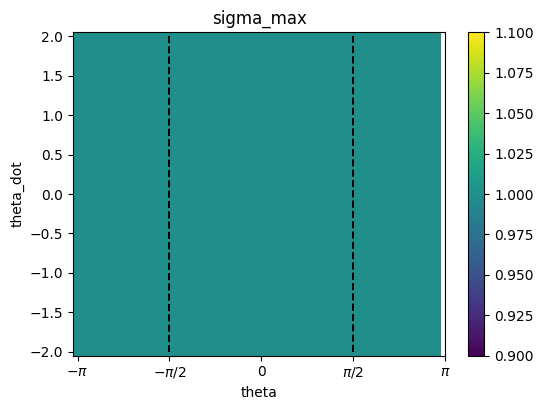

In [11]:
fig, ax = plt.subplots(figsize=(6,4.2))
im = ax.imshow(smax, extent=extent, origin='lower', aspect='auto')
ax.set_title('sigma_max')
add_det_zero_contour(ax); set_ticks_rad(ax)
plt.colorbar(im, ax=ax)
plt.show()


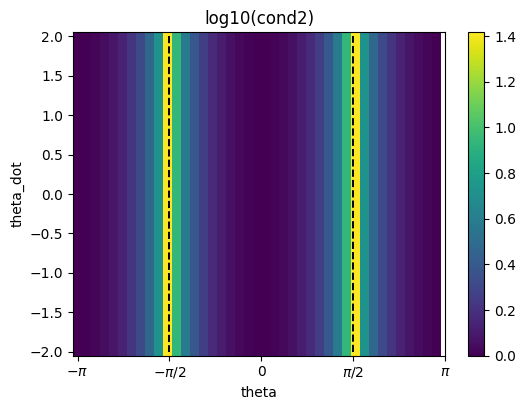

In [12]:
kappa_log = np.log10(np.clip(kappa, 1.0, 1e16))  # 稳定展示
fig, ax = plt.subplots(figsize=(6,4.2))
im = ax.imshow(kappa_log, extent=extent, origin='lower', aspect='auto')
ax.set_title('log10(cond2)')
add_det_zero_contour(ax); set_ticks_rad(ax)
plt.colorbar(im, ax=ax)
plt.show()


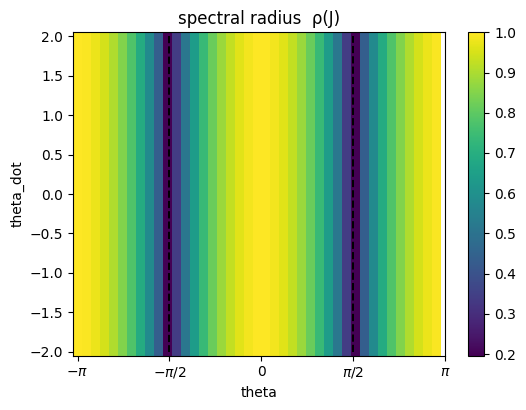

In [13]:
fig, ax = plt.subplots(figsize=(6,4.2))
im = ax.imshow(rhoJ, extent=extent, origin='lower', aspect='auto')
ax.set_title('spectral radius  ρ(J)')
add_det_zero_contour(ax); set_ticks_rad(ax)
plt.colorbar(im, ax=ax)
plt.show()


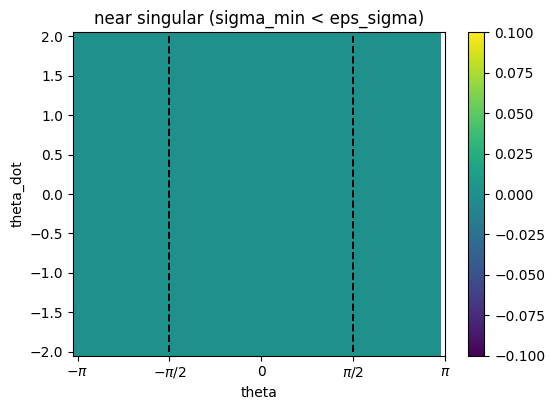

In [14]:
fig, ax = plt.subplots(figsize=(6,4.2))
im = ax.imshow(near_sing, extent=extent, origin='lower', aspect='auto')
ax.set_title('near singular (sigma_min < eps_sigma)')
add_det_zero_contour(ax); set_ticks_rad(ax)
plt.colorbar(im, ax=ax)
plt.show()



* **有限时域动力指标（可选）**：积分变分方程 $\dot\Phi=J(x(t))\Phi$，得到 **FTLE$_T$**，衡量微小扰动在有限时间内的放大率，反映**轨道敏感性**与“复杂区域”的空间分布。
* **近奇异筛查**：设置阈值（如 $\sigma_{\min}<\varepsilon$）标注潜在的不可显函数化边界或需要细化的带状区（例如 $\cos\theta\approx 0$ 一带）。
* **为后续分区与拟合提供依据**：粗网格地图用于**定位“好图”与“坏图”**：在“好图”内做显函数拟合（流映射/事件映射等），在“坏图”附近进行自适应加密或更换坐标/切片策略。最终服务于**可解 patches atlas** 的构建。
* **与无量纲化配合**：由于变量已无量纲化，指标对单位选择不敏感，$\sigma_{\min}$、FTLE 等量更具可比性，便于设定通用阈值与自动化流程。

一句话：**本阶段是在相空间上“扫地形”**——用粗网格把可逆性与敏感性的宏观结构先勾出来，从而指导后续的自适应细化与显函数拼贴。

In [ ]:
## 3.1 网格自适应加密与特征提取

In [1]:
# mosaicx_pendulum_prereq_no_energy.py
# Compute "pre-encryption" (pre-adaptation) indicators for the nondimensional pendulum
# WITHOUT using energy() or energy drift.
#
# System:
#   x1' = x2
#   x2' = -sin(x1)
#
# Indicators per grid point (x1, x2):
# - detJ, trJ
# - sigma_min, sigma_max, cond2
# - spectral_radius (rho(J))
# - FTLE_T (finite-time Lyapunov exponent over horizon T using variational equation)
# - near_singular flag (sigma_min < eps_sigma)
#
# Output: CSV with one row per initial state

import numpy as np
import pandas as pd
from typing import Tuple

# ---------- 1) Build symbolic model & lambdify ----------
import sympy as sp

# States and vector field
x1, x2 = sp.symbols('x1 x2', real=True)
f1 = x2
f2 = -sp.sin(x1)
f = sp.Matrix([f1, f2])

# Jacobian J = df/dx
J_sym = f.jacobian(sp.Matrix([x1, x2]))   # [[0, 1], [-cos(x1), 0]]

# Handy symbolic pieces
detJ_sym = sp.simplify(J_sym.det())       # = cos(x1)
trJ_sym  = sp.simplify(sp.trace(J_sym))   # = 0

# Lambdify vector field and Jacobian
f_np   = sp.lambdify((x1, x2), f, 'numpy')       # returns 2x1
J_np   = sp.lambdify((x1, x2), J_sym, 'numpy')   # returns 2x2
detJ_f = sp.lambdify((x1, x2), detJ_sym, 'numpy')
trJ_f  = sp.lambdify((x1, x2), trJ_sym,  'numpy')

# ---------- 2) Numerical routines (RK4 for state+variational) ----------
def rk4_step(state: np.ndarray, Phi: np.ndarray, dt: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    One RK4 step for:
      dx/dt = f(x)
      dPhi/dt = J(x) Phi
    """
    x1, x2 = state
    k1 = np.array(f_np(x1, x2), dtype=float).reshape(2)
    J1 = np.array(J_np(x1, x2), dtype=float)
    L1 = J1 @ Phi

    x1_2, x2_2 = state + 0.5 * dt * k1
    k2 = np.array(f_np(x1_2, x2_2), dtype=float).reshape(2)
    J2 = np.array(J_np(x1_2, x2_2), dtype=float)
    L2 = J2 @ (Phi + 0.5 * dt * L1)

    x1_3, x2_3 = state + 0.5 * dt * k2
    k3 = np.array(f_np(x1_3, x2_3), dtype=float).reshape(2)
    J3 = np.array(J_np(x1_3, x2_3), dtype=float)
    L3 = J3 @ (Phi + 0.5 * dt * L2)

    x1_4, x2_4 = state + dt * k3
    k4 = np.array(f_np(x1_4, x2_4), dtype=float).reshape(2)
    J4 = np.array(J_np(x1_4, x2_4), dtype=float)
    L4 = J4 @ (Phi + dt * L3)

    next_state = state + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
    next_Phi   = Phi   + (dt/6.0) * (L1 + 2*L2 + 2*L3 + L4)
    return next_state, next_Phi

def integrate_ftle(state0: np.ndarray, T: float = 5.0, dt: float = 0.01) -> float:
    """
    Integrate state and variational eqn over [0, T]; return FTLE_T.
    FTLE_T = (1/T) * (1/2) * log(lambda_max(C)),  C = Phi^T Phi
    """
    steps = int(round(T / dt))
    state = np.array(state0, dtype=float)
    Phi = np.eye(2, dtype=float)

    for _ in range(steps):
        state, Phi = rk4_step(state, Phi, dt)

    C = Phi.T @ Phi
    eigvals = np.linalg.eigvals(C)
    lambda_max = float(np.max(np.real(eigvals)))
    ftle = (1.0 / T) * 0.5 * np.log(lambda_max + 1e-30)  # eps to avoid log(0)
    return ftle

# ---------- 3) Pointwise algebraic indicators from J ----------
def jacobian_indicators(J: np.ndarray) -> Tuple[float, float, float, float, float]:
    """
    From a 2x2 Jacobian J, compute:
      detJ, sigma_min, sigma_max, cond2, spectral_radius
    """
    detJ = float(np.linalg.det(J))
    # SVD for singular values
    svals = np.linalg.svd(J, compute_uv=False)
    sigma_max = float(np.max(svals))
    sigma_min = float(np.min(svals))
    cond2 = sigma_max / (sigma_min + 1e-30)
    # Spectral radius (max |eigenvalue|)
    evals = np.linalg.eigvals(J)
    spectral_radius = float(np.max(np.abs(evals)))
    return detJ, sigma_min, sigma_max, cond2, spectral_radius

# ---------- 4) Grid driver (uniform, pre-adaptation) ----------
def compute_grid_prereq(
    N1: int = 41, N2: int = 41,
    x1_min: float = -np.pi, x1_max: float = np.pi,
    x2_min: float = -2.0,  x2_max: float =  2.0,
    T_horizon: float = 5.0, dt: float = 0.01,
    eps_sigma: float = 1e-3
) -> pd.DataFrame:
    """
    Compute MosaicX 'map-drawing' preconditions on a uniform grid WITHOUT energy-based metrics.
    """
    x1_vals = np.linspace(x1_min, x1_max, N1)
    x2_vals = np.linspace(x2_min, x2_max, N2)

    rows = []
    for th in x1_vals:
        for thdot in x2_vals:
            # Algebraic indicators from J at (th, thdot)
            J = np.array(J_np(th, thdot), dtype=float)
            detJ, smin, smax, cond2, rhoJ = jacobian_indicators(J)
            trJ = float(trJ_f(th, thdot))  # here equals 0 for pendulum, but keep general

            # FTLE over finite time horizon (variational eqn)
            ftle_T = integrate_ftle(np.array([th, thdot], dtype=float), T=T_horizon, dt=dt)

            rows.append({
                "x1_theta": th,
                "x2_theta_dot": thdot,
                "detJ": detJ,
                "trJ": trJ,
                "sigma_min": smin,
                "sigma_max": smax,
                "cond2": cond2,
                "spectral_radius_J": rhoJ,
                "FTLE_T": ftle_T,
                "T_horizon": T_horizon,
                "dt": dt,
                "near_singular": bool(smin < eps_sigma)
            })

    return pd.DataFrame(rows)

# ---------- 5) Main ----------
if __name__ == "__main__":
    # You can tweak these
    N1, N2 = 41, 41
    x1_min, x1_max = -np.pi, np.pi
    x2_min, x2_max = -2.0, 2.0
    T_horizon = 5.0
    dt = 0.01
    eps_sigma = 1e-3
    out_csv = "pendulum_prereq_no_energy.csv"

    df = compute_grid_prereq(
        N1=N1, N2=N2,
        x1_min=x1_min, x1_max=x1_max,
        x2_min=x2_min, x2_max=x2_max,
        T_horizon=T_horizon, dt=dt,
        eps_sigma=eps_sigma
    )
    df.to_csv(out_csv, index=False)

    # Small console summary
    print(f"Saved {len(df)} rows to {out_csv}")
    for k in ["sigma_min", "cond2", "FTLE_T", "spectral_radius_J"]:
        arr = df[k].to_numpy()
        print(f"{k:>18s}  min={arr.min(): .3e}  med={np.median(arr): .3e}  max={arr.max(): .3e}")
    print(f"near_singular count: {df['near_singular'].sum()} (threshold eps_sigma={eps_sigma})")


Saved 1681 rows to pendulum_prereq_no_energy.csv
         sigma_min  min= 6.123e-17  med= 7.071e-01  max= 1.000e+00
             cond2  min= 1.000e+00  med= 1.414e+00  max= 1.633e+16
            FTLE_T  min=-6.943e-13  med= 2.684e-01  max= 1.000e+00
 spectral_radius_J  min= 7.825e-09  med= 8.409e-01  max= 1.000e+00
near_singular count: 82 (threshold eps_sigma=0.001)


In [ ]:
## 2.2 

对的！拿到 **一阶系统的 Jacobian**

$$
J(\theta)=\begin{bmatrix}0&1\\-\cos\theta&0\end{bmatrix}
$$

之后，就可以把你离散数据里的每个 $\theta_i$ **直接代入**来算指标了。

**保守单摆的闭式结果（超省事）：**

* 行列式：$\det J_i=\cos\theta_i$
* 奇异值：$\sigma_{\min,i}=|\cos\theta_i|$、$\sigma_{\max,i}=1$
* 条件数：$\kappa_i=1/|\cos\theta_i|$

**数值例子（弧度）：**

* $\theta=0$: $\det=1$, $\sigma_{\min}=1$, $\kappa=1$（最稳）
* $\theta=\pi/3\approx1.047$: $\cos\theta=0.5\Rightarrow \det=0.5$, $\sigma_{\min}=0.5$, $\kappa=2$
* $\theta=\pi/2-0.01$: $\cos\theta\approx0.01\Rightarrow \sigma_{\min}\approx0.01$, $\kappa\approx100$（接近奇异）
* $\theta=\pi/2$: $\cos\theta=0\Rightarrow \sigma_{\min}=0$, $\kappa=\infty$（奇异边界）

**实操清单：**

1. 确保 $\theta$ 用弧度（必要时 `unwrap`）。
2. 对每个样本计算 $|\cos\theta_i|$；设阈值 $\tau$（如 0.05），做分区：

   * 良态：$|\cos\theta_i|\ge\tau$
   * 边界：$|\cos\theta_i|<\tau$
3. 画时间序列或相图热力图（$|\cos\theta|$、$\kappa$）。
4. 在良态区做你后续的显函数拟合；靠近 $\pi/2+k\pi$ 的样本谨慎/分片处理。

> 若日后加入阻尼 $\zeta$：$J=\begin{bmatrix}0&1\\-\cos\theta&-2\zeta\end{bmatrix}$。这时用样本点数值算 SVD/特征值即可（$\det=\cos\theta$ 仍然是奇异判据）。


# 3. 单摆模型函数结构解析
